In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import color

In [4]:
img = color.rgb2gray(skimage.data.astronaut())

In [5]:
def compute_gradients(image):
    grad_x=cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    magnitude = np.sqrt(grad_x ** 2 + grad_y ** 2)
    angle = np.arctan2(grad_y, grad_x) * (180 / np.pi) % 180  # Convert to degrees in [0,180)
    
    return magnitude, angle

In [6]:
magnitude, angle = compute_gradients(img)

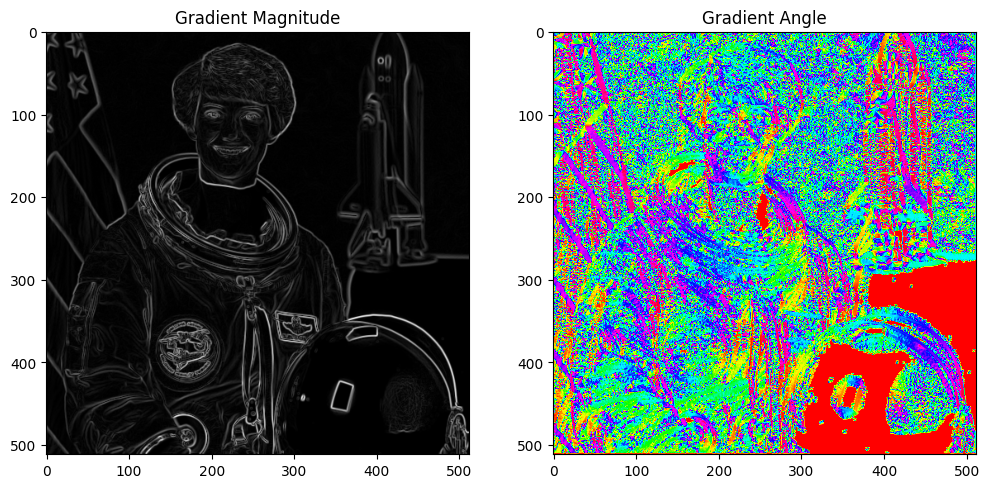

In [7]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(magnitude, cmap='gray')
plt.title('Gradient Magnitude')
plt.subplot(1, 2, 2)
plt.imshow(angle, cmap='hsv')
plt.title('Gradient Angle')
plt.show()

In [8]:
def histogram_of_gradients(magnitude, angle, cell_size=8, bin_size=9):
    # Calculate the range for bins
    bins_range = np.linspace(0, 180, bin_size + 1)  # Bin edges for [0,180) with `bin_size` bins
    h, w = magnitude.shape
    # Number of cells in x and y directions
    cells_x, cells_y = w // cell_size, h // cell_size
    hog_features = np.zeros((cells_y, cells_x, bin_size))

    for i in range(cells_y):
        for j in range(cells_x):
            # Get cell magnitude and angle
            cell_magnitude = magnitude[i * cell_size:(i + 1) * cell_size,
                                       j * cell_size:(j + 1) * cell_size]
            cell_angle = angle[i * cell_size:(i + 1) * cell_size,
                               j * cell_size:(j + 1) * cell_size]
            
            # Create histogram for the current cell
            hist, _ = np.histogram(cell_angle, bins=bins_range, weights=cell_magnitude)
            hog_features[i, j, :] = hist  # Store histogram for each cell

    return hog_features

# Example usage
magnitude, angle = compute_gradients(img)  # from the previous step
cell_size = 8
bin_size = 9
hog_features = histogram_of_gradients(magnitude, angle, cell_size, bin_size)

print("HOG features shape (cells_y, cells_x, bins):", hog_features.shape)


HOG features shape (cells_y, cells_x, bins): (64, 64, 9)


In [9]:
print(hog_features)

[[[8.36088524e+00 4.38224989e+00 1.56636779e-01 ... 2.27491419e+00
   1.71114762e-01 4.23999813e-01]
  [1.60204883e+01 2.05907063e+01 0.00000000e+00 ... 0.00000000e+00
   7.28061583e-01 4.16353323e+00]
  [7.51808802e-01 1.42265950e-01 0.00000000e+00 ... 1.97049004e-01
   1.73519007e-01 2.36640185e+00]
  ...
  [3.03736662e-01 1.30665626e-01 2.94119593e-02 ... 3.32739089e-01
   3.95489571e-01 1.32728860e-01]
  [2.94095232e-01 9.09874759e-02 1.90951450e-01 ... 2.10559139e-01
   3.58766621e-01 1.20830161e-01]
  [4.47035996e-01 2.09071100e-01 2.88316211e-01 ... 1.81076601e-01
   8.75929042e-02 1.10375429e-01]]

 [[2.43488967e+00 4.84470493e-01 3.88056744e+00 ... 7.43337599e-02
   5.18587874e+00 3.96984156e+00]
  [1.36546968e+00 5.38598523e-01 3.47965520e-01 ... 0.00000000e+00
   3.47213421e+01 8.42257011e+00]
  [1.42316880e+00 2.21829399e+00 0.00000000e+00 ... 0.00000000e+00
   4.59532072e-01 2.44275187e+00]
  ...
  [1.33609723e-01 5.84906074e-02 7.49883627e-02 ... 8.82544850e-01
   3.58864

C:\Users\lenovo\AppData\Local\Temp\ipykernel_11744\2267087780.py:18: RuntimeWarning: invalid value encountered in scalar divide
  line_length = cell_hist[b] / max_val * (cell_size / 2)


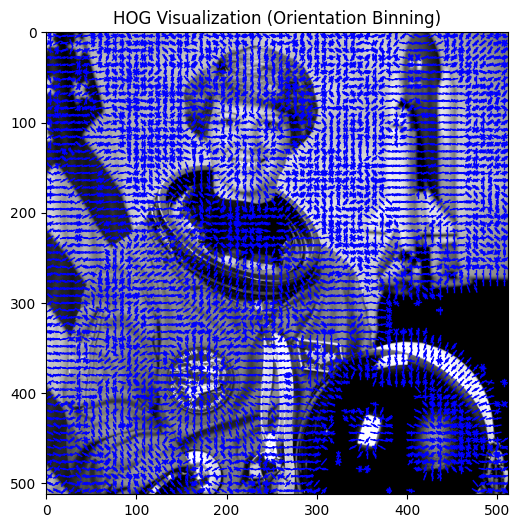

In [10]:
def visualize_hog(img, hog_features, cell_size=8, bin_size=9):
    h, w = img.shape
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(img, cmap='gray')
    
    # Define the angles for each bin (center of each bin range)
    bin_angles = np.linspace(0, 180, bin_size + 1)[:-1] + (180 / bin_size) / 2

    for i in range(hog_features.shape[0]):
        for j in range(hog_features.shape[1]):
            cell_hist = hog_features[i, j, :]
            max_val = cell_hist.max()  # Normalization for visualization
            for b in range(bin_size):
                angle = bin_angles[b]
                angle_rad = np.deg2rad(angle)

                # Scale line length based on histogram value in the cell's bin
                line_length = cell_hist[b] / max_val * (cell_size / 2)

                # Calculate start and end points of the line within the cell
                center_x = j * cell_size + cell_size // 2
                center_y = i * cell_size + cell_size // 2
                dx = line_length * np.cos(angle_rad)
                dy = line_length * np.sin(angle_rad)

                # Draw the line for each bin
                ax.plot([center_x - dx, center_x + dx],
                        [center_y - dy, center_y + dy], color='blue', linewidth=1)

    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    ax.set_title("HOG Visualization (Orientation Binning)")
    plt.show()

# Example usage:
visualize_hog(img, hog_features, cell_size=8, bin_size=9)


In [11]:
def normalize_blocks(hog_features, cell_size=8, block_size=2, bin_size=9):
    cells_y, cells_x, _ = hog_features.shape
    # Define the number of blocks
    blocks_y = cells_y - block_size + 1
    blocks_x = cells_x - block_size + 1
    # Prepare the normalized HOG feature array
    normalized_hog = np.zeros((blocks_y, blocks_x, block_size * block_size * bin_size))

    for y in range(blocks_y):
        for x in range(blocks_x):
            # Extract the block (2x2 cells) and concatenate histograms
            block_hist = hog_features[y:y + block_size, x:x + block_size, :].ravel()

            # Apply L2 normalization
            norm = np.sqrt(np.sum(block_hist ** 2) + 1e-5)
            normalized_block = block_hist / norm

            # Store normalized block in the result
            normalized_hog[y, x, :] = normalized_block

    return normalized_hog

# Example usage:
normalized_hog_features = normalize_blocks(hog_features, cell_size=8, block_size=2, bin_size=9)
print("Normalized HOG features shape:", normalized_hog_features.shape)


Normalized HOG features shape: (63, 63, 36)


In [12]:
print(normalized_hog_features)

[[[1.72495211e-01 9.04111346e-02 3.23160689e-03 ... 0.00000000e+00
   7.16343434e-01 1.73767845e-01]
  [3.58421645e-01 4.60669780e-01 0.00000000e+00 ... 0.00000000e+00
   1.02809751e-02 5.46509648e-02]
  [3.16555701e-02 5.99023280e-03 0.00000000e+00 ... 2.67286343e-03
   1.98313842e-03 5.16592214e-02]
  ...
  [1.92597173e-01 3.41038342e-02 2.49636512e-02 ... 3.02089482e-01
   1.22836886e-01 1.05528959e-01]
  [1.76583737e-01 7.59652272e-02 1.70992650e-02 ... 1.80958633e-01
   2.55786047e-01 2.32843616e-01]
  [2.07623952e-01 6.42349050e-02 1.34806996e-01 ... 1.84995785e-01
   1.25649223e-01 8.51374511e-02]]

 [[5.00225817e-02 9.95300327e-03 7.97227096e-02 ... 2.01989309e-03
   9.04601236e-03 6.28068934e-02]
  [3.56076623e-02 1.40451557e-02 9.07397570e-03 ... 1.00527020e-02
   8.01775325e-02 8.65699920e-02]
  [4.25271247e-02 6.62870528e-02 0.00000000e+00 ... 9.79099270e-02
   7.55344104e-02 1.11591837e-01]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.97553986e-01
   1.29167

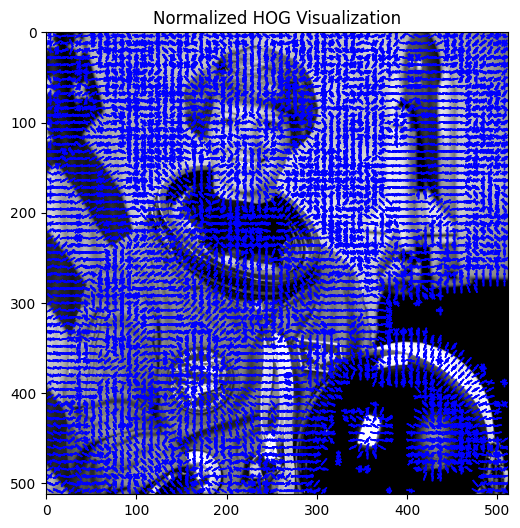

In [13]:
def visualize_normalized_hog(img, normalized_hog, cell_size=8, block_size=2, bin_size=9):
    h, w = img.shape
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(img, cmap='gray')

    # Define bin angles
    bin_angles = np.linspace(0, 180, bin_size + 1)[:-1] + (180 / bin_size) / 2

    blocks_y, blocks_x, _ = normalized_hog.shape
    for y in range(blocks_y):
        for x in range(blocks_x):
            block_vector = normalized_hog[y, x, :].reshape(block_size, block_size, bin_size)
            for i in range(block_size):
                for j in range(block_size):
                    cell_hist = block_vector[i, j, :]
                    max_val = cell_hist.max()  # Normalization for visualization
                    for b in range(bin_size):
                        angle = bin_angles[b]
                        angle_rad = np.deg2rad(angle)

                        # Scale line length based on normalized histogram value
                        line_length = cell_hist[b] / max_val * (cell_size / 2) if max_val != 0 else 0

                        # Calculate line start and end points
                        center_x = (x + j) * cell_size + cell_size // 2
                        center_y = (y + i) * cell_size + cell_size // 2
                        dx = line_length * np.cos(angle_rad)
                        dy = line_length * np.sin(angle_rad)

                        # Draw line for each orientation bin in the cell
                        ax.plot([center_x - dx, center_x + dx],
                                [center_y - dy, center_y + dy], color='blue', linewidth=1)

    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    ax.set_title("Normalized HOG Visualization")
    plt.show()

# Example usage:
visualize_normalized_hog(img, normalized_hog_features, cell_size=8, block_size=2, bin_size=9)
